In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from scipy import interpolate

In [ ]:
kbT = 0.4

D = 6
H = 8 * D
L = 50 * D
n = 10

# H = 30
# L = 50
# n = 35

v_max = 0.2

N = n * L * H
r = np.zeros((N, 2), dtype=np.float32)
v = np.random.normal(0, np.sqrt(kbT), (N, 2)).astype(np.float32)

y0 = (H-D)/2
x0 = L/4 - D/2

delta = 0.25

for i in range(L):
    for j in range(H):
        # if (i >= x0) and (i < (x0+D)) and (j >= y0) and (j < (y0+D)):
        #     continue
        r[(i*H+j)*n:(i*H+j+1)*n, :] = np.random.rand(n, 2) + np.array([i, j])

r[:, 1] = r[:, 1] - delta

# in_D = (r[:, 1] > y0) & (r[:, 1] < (y0+D)) & (r[:, 0] > x0) & (r[:, 0] < (x0+D))
# r[in_D, 1] = r[in_D, 1] - D

intake = r[:, 0] <= 10
v[intake, 0] += 4*v_max * ((H-delta) - r[intake, 1]) * (r[intake, 1] + delta) / H**2

In [ ]:
R_plus = np.array([[0., -1.], [1., 0.]], dtype=np.float32)
R_minus = np.array([[0., 1.], [-1., 0.]], dtype=np.float32)

In [ ]:
@njit(fastmath=True)
def bb_walls(r, v):
    # bounce-back rule for walls
    to_bounce = r[:, 1] <= -delta
    tac = (r[to_bounce, 1] + delta) / v[to_bounce, 1]
    r[to_bounce, 0] = r[to_bounce, 0] - 2*v[to_bounce, 0]*tac
    r[to_bounce, 1] = r[to_bounce, 1] - 2*v[to_bounce, 1]*tac
    tau = 2*np.sum(v[to_bounce, 0]) / L
    v[to_bounce] = -v[to_bounce]
    
    to_bounce = r[:, 1] >= (H-delta)
    tac = (r[to_bounce, 1] - (H-delta)) / v[to_bounce, 1]
    r[to_bounce, 0] = r[to_bounce, 0] - 2*v[to_bounce, 0]*tac
    r[to_bounce, 1] = r[to_bounce, 1] - 2*v[to_bounce, 1]*tac
    tau += 2*np.sum(v[to_bounce, 0]) / L
    v[to_bounce] = -v[to_bounce]

    return r, v, tau


@njit(fastmath=True)
def bb_cilinder(r, v):
    t_x0 = (r[:, 0] - x0) / v[:, 0]
    t_y0 = (r[:, 1] - y0) / v[:, 1]
    t_x0D = (r[:, 0] - (x0+D)) / v[:, 0]
    t_y0D = (r[:, 1] - (y0+D)) / v[:, 1]
    
    in_x0 = (t_x0 < 1) & (t_x0 > 0)
    y_in_x0 = r[:, 1] - v[:, 1] * t_x0
    in_x0 = in_x0 & (y_in_x0 < (y0+D)) & (y_in_x0 > y0)
    
    in_x0D = (t_x0D < 1) & (t_x0D > 0)
    y_in_x0D = r[:, 1] - v[:, 1] * t_x0D
    in_x0D = in_x0D & (y_in_x0D < (y0+D)) & (y_in_x0D > y0)
    
    in_y0 = (t_y0 < 1) & (t_y0 > 0)
    x_in_y0 = r[:, 0] - v[:, 0] * t_y0
    in_y0 = in_y0 & (x_in_y0 < (x0+D)) & (x_in_y0 > x0)
    
    in_y0D = (t_y0D < 1) & (t_y0D > 0)
    x_in_y0D = r[:, 0] - v[:, 0] * t_y0D
    in_y0D = in_y0D & (x_in_y0D < (x0+D)) & (x_in_y0D > x0)
    
    both = (in_x0 & in_y0)
    in_x0[both] = t_x0[both] > t_y0[both]
    in_y0[both] = t_x0[both] < t_y0[both]
    
    both = (in_x0 & in_y0D)
    in_x0[both] = t_x0[both] > t_y0D[both]
    in_y0D[both] = t_x0[both] < t_y0D[both]
    
    both = (in_x0D & in_y0D)
    in_x0D[both] = t_x0D[both] > t_y0D[both]
    in_y0D[both] = t_x0D[both] < t_y0D[both]
    
    both = (in_x0D & in_y0)
    in_x0D[both] = t_x0D[both] > t_y0[both]
    in_y0[both] = t_x0D[both] < t_y0[both]
    
    r[in_x0, 0] = r[in_x0, 0] - 2*v[in_x0, 0]*t_x0[in_x0]
    r[in_x0, 1] = r[in_x0, 1] - 2*v[in_x0, 1]*t_x0[in_x0]
    
    r[in_y0, 0] = r[in_y0, 0] - 2*v[in_y0, 0]*t_y0[in_y0]
    r[in_y0, 1] = r[in_y0, 1] - 2*v[in_y0, 1]*t_y0[in_y0]
    
    r[in_x0D, 0] = r[in_x0D, 0] - 2*v[in_x0D, 0]*t_x0D[in_x0D]
    r[in_x0D, 1] = r[in_x0D, 1] - 2*v[in_x0D, 1]*t_x0D[in_x0D]
    
    r[in_y0D, 0] = r[in_y0D, 0] - 2*v[in_y0D, 0]*t_y0D[in_y0D]
    r[in_y0D, 1] = r[in_y0D, 1] - 2*v[in_y0D, 1]*t_y0D[in_y0D]
    
    f_par = 2*np.sum(v[in_x0, 0]) + 2*np.sum(v[in_x0D, 0])
    f_par += 2*np.sum(v[in_y0, 0]) + 2*np.sum(v[in_y0D, 0])
    
    v[in_x0, :] = -v[in_x0, :]
    v[in_y0, :] = -v[in_y0, :]
    v[in_x0D, :] = -v[in_x0D, :]
    v[in_y0D, :] = -v[in_y0D, :]

    return r, v, f_par


@njit(fastmath=True)
def cell_collision(v_cell):
    u = np.sum(v_cell, axis=0) / v_cell.shape[0]

    if np.random.rand() > 0.5:
        v_cell = u + np.dot(v_cell-u, R_plus)  # should transpose but symmetry
    else:
        v_cell = u + np.dot(v_cell-u, R_minus) # should transpose but symmetry

    return v_cell


@njit(parallel=True, fastmath=True)
def update(r, v):

    r += v
    
    r, v, tau = bb_walls(r, v)
    # pbc on x
    r[r[:, 0] > L, 0] = r[r[:, 0] > L, 0] - L
    r[r[:, 0] <= 0, 0] = r[r[:, 0] <= 0, 0] + L

    # r, v, f = bb_cilinder(r, v)

    # eps = np.random.rand(L*H)

    for i in prange(L):
        # first shifted cell
        # cell = (r[:, 0] > i) & (r[:, 0] <= (i+1)) & (r[:, 1] > -delta) & (r[:, 1] <= 0)
        # v_cell = v[cell, :]

        # v_cell = cell_collision(v_cell)
    
        # bulk cells
        for j in range(-1, H):
            # if (i >= x0) and (i < (x0+D)) and (j >= y0) and (j < (y0+D)):
            #     continue

            cell = (r[:, 0] > i) & (r[:, 0] <= (i+1)) & (r[:, 1] > j) & (r[:, 1] <= (j+1))
            v_cell  = v[cell, :]

            v[cell, :] = cell_collision(v_cell)
    
        # # last shifted cell
        # cell = (r[:, 0] > i) & (r[:, 0] <= (i+1)) & (r[:, 1] > (H-1)) & (r[:, 1] <= (H-delta))
        # v_cell  = v[cell, :]
        
        # v_cell = cell_collision(v_cell)
    
    intake = r[:, 0] <= 10
    v[intake, 0] = np.random.normal(0, np.sqrt(kbT), np.sum(intake))
    v[intake, 0] += 4*v_max * ((H-delta) - r[intake, 1]) * (r[intake, 1] + delta) / H**2
    return r, v, tau

In [ ]:
r, v, tau = update(r, v)
%timeit -n 5 -r 100 update(r, v)

In [2]:
D = 12
H = 8 * D
L = 50 * D
n = 10

x0 = L/4 - D/2
y0 = (H-D)/2

v_max = 0.2
nu = 0.108
Re = D*v_max/nu

# r = np.load(f"data/rD{D}.npy")
# v = np.load(f"data/vD{D}.npy")

print(f"Re = {Re:.1f}")

v_rec = np.load(f"data/v_recD{D}.npy")
f_par = np.load(f"data/f_parD{D}.npy")

v_err = np.std(v_rec, axis=0, where=((~np.isnan(v_rec)) & (v_rec!=0))) / np.sqrt(v_rec.shape[0] - np.count_nonzero(np.isnan(v_rec), axis=0))
v_rec = np.mean(v_rec, axis=0, where=((~np.isnan(v_rec)) & (v_rec!=0)))

Re = 22.2


In [3]:
2*np.mean(f_par) / (n*v_max**2*D), 2*np.std(f_par) / np.sqrt(f_par.shape[0]) / (n*v_max**2*D)

(2.267244582935698, 0.030426270319280826)

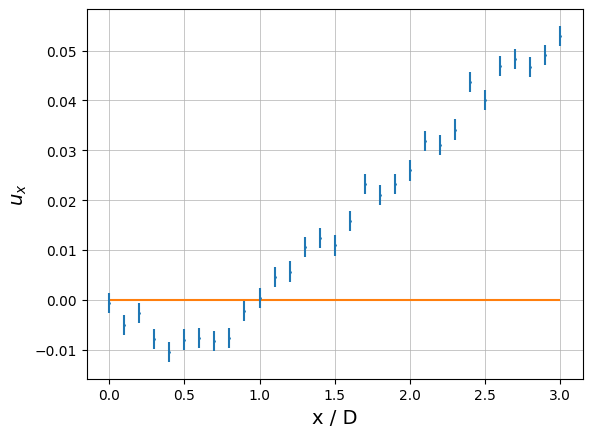

In [4]:
plt.hlines(0, 0, 3, color="tab:orange")
plt.errorbar(np.arange(v_rec.shape[0])*D*0.1 / D, v_rec, yerr=v_err, fmt=".", ms=2)


plt.xlabel("x / D", fontsize=14)
plt.ylabel("$u_x$", fontsize=14)
plt.grid(linewidth=0.5)
plt.savefig("lr_ex.pdf")
plt.show()

In [5]:
Re = [11.1, 22.2, 33.3, 44.4]
Lr = [0.5, 1.1, 1.7, 2.3]
d_Lr = 4*[0.05]

Re_p = [9.898481467446985,  
        19.798941798941797, 
        29.765539696574173, 
        39.704244031830235]

Lr_p = [0.40847578347578306,
        1.0316951566951569,
        1.4928774928774933,
        1.9220085470085475]

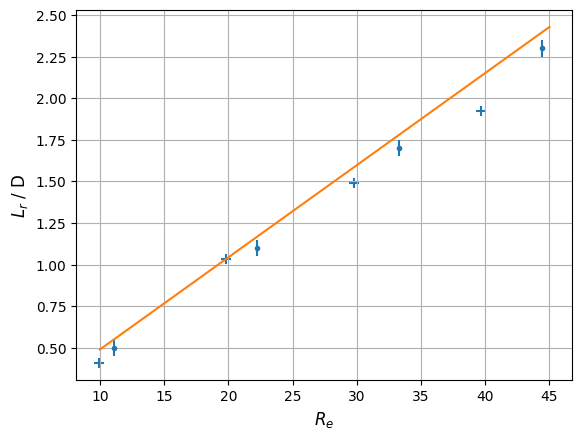

In [6]:
plt.errorbar(Re, Lr, yerr=d_Lr, fmt=".")
plt.scatter(Re_p, Lr_p, marker="+", s=50)
plt.plot(np.linspace(10, 45), -0.065+np.linspace(10, 45)*0.0554)

plt.xlabel("$R_e$", fontsize=12)
plt.ylabel("$L_r$ / D", fontsize=12)
plt.grid()
plt.savefig("lr.pdf")

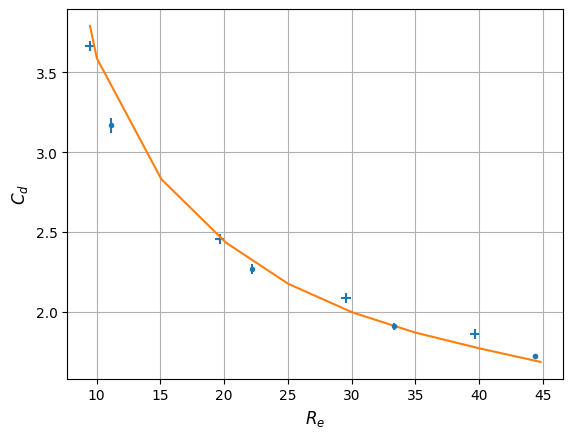

In [7]:
Cd = np.array([[3.1679316135768603, 0.04596264854680024],
               [2.2678110236703617, 0.03188012626327445],
               [1.9063646597532753, 0.020660793122013563],
               [1.7186620607172278, 0.016299450935653294]])

Re_p = [9.449795397435505, 
        19.655403593456693, 
        29.55063168558745, 
        39.69695728176556]

Cdp = [3.665744837758112,
       2.4535398230088497,
       2.0832718780727633,
       1.8589601769911508]

Re_th = [
9.473734158079079,
10.013487793439502, 
15.07017197809532, 
20.13046471725441, 
25.012348118772575, 
30.03681326888133, 
34.93667418090108, 
40.03456597459471, 
44.815170403141785]

Cd_th = [
3.7920623630891286,
3.5883308543044423,
2.830443182749168,
2.4328945151119186,
2.1740475428502766,
1.9950884818903878,
1.8686926396648702,
1.7682956697628185,
1.683591283780578]

plt.errorbar(Re, Cd[:, 0], yerr=Cd[:, 1], fmt=".")
plt.scatter(Re_p, Cdp, marker="+", s=50)
plt.plot(Re_th, Cd_th)

plt.xlabel("$R_e$", fontsize=12)
plt.ylabel("$C_d$", fontsize=12)
plt.grid()
plt.savefig("cd.pdf")

In [8]:
D = 6
H = 8*D

G = 0.000727
d_G = 0.000014

ux = np.load("data/ux.npy")

In [9]:
from scipy.optimize import curve_fit

delta = 0.25
f_fit = lambda y, A:  A / 2 * (H-delta-y)*(y+delta)

y = np.arange(H) + 0.5 - delta
popt, pcov = curve_fit(f_fit, y, ux[:, 0], sigma=ux[:, 1])

In [10]:
nu = G / popt[0] / n
d_nu = np.sqrt((d_G/G)**2 + pcov[0][0]/popt[0]**2) / n

print(f"Fit nu: {nu:.4f} \u00B1 {d_nu:.4f}")

Fit nu: 0.1080 ± 0.0020


In [11]:
nu = G * H**2 / (8 * v_max * n)
d_nu = d_G * H**2 / (8 * v_max * n)

print(f"Theory nu: {nu:.4f} \u00B1 {d_nu:.4f}")

Theory nu: 0.1047 ± 0.0020


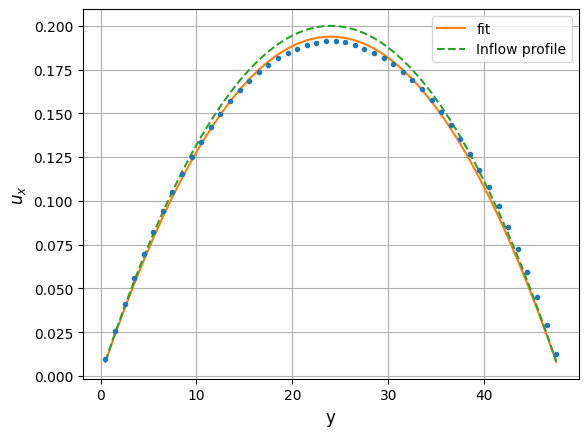

In [12]:
ux = np.load("data/ux.npy")

D = 6
H = 8*D

y = np.arange(H)+0.5
plt.errorbar(y, ux[:, 0], fmt=".", yerr=ux[:, 1], )
plt.plot(y, f_fit(y-delta, *popt), label="fit")
plt.plot(y, 4*v_max * (H - y) * y / H**2, linestyle="dashed", label="Inflow profile")
plt.legend()
plt.grid()
plt.xlabel("y", fontsize=12)
plt.ylabel("$u_x$", fontsize=12)
plt.savefig("ux.pdf")